# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "RF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'RF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_109  P0DMQ5           20.264
Sample_139  D6RJG0;Q9Y6N8    15.495
Sample_041  Q6YHK3           15.161
Sample_084  Q86Y38           15.251
Sample_174  P02652;V9GYM3    22.422
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by RF: runs/alzheimer_study/preds/pred_real_na_RF.csv


Sample ID   protein groups                                                           
Sample_183  H0Y6Q1;O75354;O75354-2;O75354-3;Q5QPI7;Q5QPI9;Q5QPJ3;Q5QPJ4;Q5QPJ6;Q5QPJ7   14.695
Sample_177  P36269;P36269-2;P36269-3                                                    12.380
Sample_185  O94919                                                                      18.633
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.029
            A0A075B6Q5                 12.729
            A0A075B6R2                 13.240
            A0A075B6S5                 13.089
            A0A087WSY4                 12.549
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.303
            Q9UI40;Q9UI40-2            12.370
            Q9UIW2                     12.320
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   11.279
            Q9UP79                     12.332
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.235,15.050,16.842,19.863,15.805,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.642,19.067,...,15.528,15.576,14.241,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.514,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.469,17.705,17.039,16.435,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.505,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.637,15.345,17.084,18.708,14.249,19.433,12.059,11.157
Sample_207,15.739,16.877,15.469,16.898,16.062,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.054,12.255,11.975,13.242,11.883,13.109,11.153,13.294,12.777,13.124
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.754,19.067,16.127,...,12.993,12.217,12.190,11.369,13.545,13.614,12.049,11.676,11.374,13.771
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,13.242,13.906,11.957,12.867,13.374,12.227,12.045,13.249,13.792,14.399
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,12.725,12.958,13.615,13.356,13.480,11.386,11.900,13.273,13.367,12.579
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,13.175,12.398,13.391,12.014,14.957,13.042,12.038,13.502,13.676,12.916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.365,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 296.61it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

100%|██████████| 2/2 [00:00<00:00,  5.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  6.55it/s]

100%|██████████| 3/3 [00:00<00:00,  5.17it/s]

100%|██████████| 3/3 [00:00<00:00,  5.37it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.28it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  5.23it/s]

100%|██████████| 4/4 [00:00<00:00,  4.83it/s]

100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.42it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.70it/s]

 80%|████████  | 4/5 [00:00<00:00,  4.55it/s]

100%|██████████| 5/5 [00:01<00:00,  4.52it/s]

100%|██████████| 5/5 [00:01<00:00,  4.71it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.13it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.61it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  4.61it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  4.26it/s]

100%|██████████| 6/6 [00:01<00:00,  4.43it/s]

100%|██████████| 6/6 [00:01<00:00,  4.75it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  8.78it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.09it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.48it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.17it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.90it/s]

100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

100%|██████████| 7/7 [00:01<00:00,  4.31it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.27it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.37it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.41it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.34it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.04it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.01it/s]

100%|██████████| 8/8 [00:01<00:00,  4.15it/s]

100%|██████████| 8/8 [00:01<00:00,  4.40it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.57it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.42it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.52it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.14it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.05it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.88it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.85it/s]

100%|██████████| 9/9 [00:02<00:00,  4.03it/s]

100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.06it/s]

 30%|███       | 3/10 [00:00<00:01,  5.11it/s]

 40%|████      | 4/10 [00:00<00:01,  4.28it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.98it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.97it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.78it/s]

 80%|████████  | 8/10 [00:01<00:00,  3.81it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.84it/s]

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]

100%|██████████| 10/10 [00:02<00:00,  4.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  7.48it/s]

 27%|██▋       | 3/11 [00:00<00:01,  5.25it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.56it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.36it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.15it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.01it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  3.96it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.82it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.92it/s]

100%|██████████| 11/11 [00:02<00:00,  4.02it/s]

100%|██████████| 11/11 [00:02<00:00,  4.23it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.46it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.37it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.19it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.55it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.46it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.20it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.24it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.22it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  4.28it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.45it/s]

100%|██████████| 12/12 [00:02<00:00,  4.40it/s]

100%|██████████| 12/12 [00:02<00:00,  4.62it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  4.89it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.77it/s]

 31%|███       | 4/13 [00:01<00:02,  3.31it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.13it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.11it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.09it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.96it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.90it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.94it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.89it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  2.91it/s]

100%|██████████| 13/13 [00:04<00:00,  3.28it/s]

100%|██████████| 13/13 [00:04<00:00,  3.17it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.41it/s]

 21%|██▏       | 3/14 [00:00<00:02,  5.04it/s]

 29%|██▊       | 4/14 [00:00<00:02,  4.62it/s]

 36%|███▌      | 5/14 [00:01<00:02,  4.22it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.95it/s]

 50%|█████     | 7/14 [00:01<00:01,  3.85it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  3.81it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  3.96it/s]

 71%|███████▏  | 10/14 [00:02<00:01,  3.96it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.09it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  3.99it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  3.46it/s]

100%|██████████| 14/14 [00:03<00:00,  3.33it/s]

100%|██████████| 14/14 [00:03<00:00,  3.90it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.94it/s]

 20%|██        | 3/15 [00:00<00:02,  5.46it/s]

 27%|██▋       | 4/15 [00:00<00:02,  4.06it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.62it/s]

 40%|████      | 6/15 [00:01<00:02,  3.24it/s]

 47%|████▋     | 7/15 [00:01<00:02,  2.98it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.93it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.16it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.12it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.21it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.29it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.54it/s]

 93%|█████████▎| 14/15 [00:03<00:00,  3.83it/s]

100%|██████████| 15/15 [00:04<00:00,  4.10it/s]

100%|██████████| 15/15 [00:04<00:00,  3.62it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.003 0.000      0.032 0.005          0.788 0.316       0.134   
2             0.003 0.000      0.037 0.006          0.648 0.137       0.534   
3             0.003 0.000      0.037 0.006          0.730 0.105       0.640   
4             0.004 0.002      0.037 0.006          0.771 0.091       0.680   
5             0.004 0.002      0.037 0.008          0.719 0.082       0.682   
6             0.004 0.002      0.038 0.009          0.741 0.088       0.740   
7             0.003 0.000      0.035 0.005          0.735 0.088       0.735   
8             0.004 0.002      0.037 0.009          0.818 0.078       0.824   
9             0.004 0.002      0.039 0.011          0.822 0.073       0.810   
10            0.004 0.002      0.038 0.009          0.805 0.086       0.820   
11            0.004 0.003      0.044 0.017          0.820 0.084       0.828   
12            0.005 0.004      0.046 0.024          0.823 0.081       0.823   
13            0.005 0.003      0.047 0.018          0.821 0.083       0.824   
14            0.005 0.004      0.048 0.016          0.824 0.077       0.828   
15            0.005 0.004      0.045 0.022          0.823 0.077       0.829   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.091   0.220 0.134                  0.559 0.044        0.857   
2          0.142   0.574 0.117                  0.656 0.080        0.731   
3          0.118   0.675 0.093                  0.731 0.068        0.786   
4          0.114   0.716 0.084                  0.765 0.063        0.818   
5          0.095   0.696 0.072                  0.743 0.058        0.865   
6          0.113   0.735 0.079                  0.773 0.065        0.876   
7          0.111   0.730 0.079                  0.769 0.066        0.874   
8          0.099   0.817 0.068                  0.843 0.056        0.917   
9          0.101   0.811 0.065                  0.839 0.053        0.916   
10         0.106   0.808 0.078                  0.835 0.067        0.916   
11         0.101   0.821 0.078                  0.847 0.067        0.920   
12         0.102   0.820 0.076                  0.846 0.064        0.920   
13         0.100   0.819 0.074                  0.845 0.063        0.919   
14         0.104   0.822 0.073                  0.848 0.062        0.918   
15         0.105   0.822 0.072                  0.848 0.062        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.068                  0.830 0.092        210.000 0.000  
2          0.087                  0.679 0.098        210.000 0.000  
3          0.065                  0.737 0.086        210.000 0.000  
4          0.065                  0.787 0.092        210.000 0.000  
5          0.053                  0.844 0.060        210.000 0.000  
6          0.052                  0.842 0.065        210.000 0.000  
7          0.052                  0.840 0.065        210.000 0.000  
8          0.044                  0.907 0.045        210.000 0.000  
9          0.044                  0.906 0.046        210.000 0.000  
10         0.046                  0.905 0.048        210.000 0.000  
11         0.046                  0.907 0.048        210.000 0.000  
12         0.046                  0.903 0.051        210.000 0.000  
13         0.046                  0.903 0.051        210.000 0.000  
14         0.046                  0.901 0.052        210.000 0.000  
15         0.046                  0.900 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 519.68it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

100%|██████████| 2/2 [00:00<00:00,  6.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.12it/s]

100%|██████████| 3/3 [00:00<00:00,  3.62it/s]

100%|██████████| 3/3 [00:00<00:00,  3.80it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.72it/s]

100%|██████████| 4/4 [00:01<00:00,  3.10it/s]

100%|██████████| 4/4 [00:01<00:00,  3.49it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  6.95it/s]

 60%|██████    | 3/5 [00:00<00:00,  4.27it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.69it/s]

100%|██████████| 5/5 [00:01<00:00,  3.33it/s]

100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.91it/s]

 50%|█████     | 3/6 [00:00<00:00,  4.24it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.78it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.69it/s]

100%|██████████| 6/6 [00:01<00:00,  3.08it/s]

100%|██████████| 6/6 [00:01<00:00,  3.53it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  7.40it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.77it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.08it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.66it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.79it/s]

100%|██████████| 7/7 [00:01<00:00,  3.79it/s]

100%|██████████| 7/7 [00:01<00:00,  4.06it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.33it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.67it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.10it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.88it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  3.61it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  3.78it/s]

100%|██████████| 8/8 [00:01<00:00,  3.89it/s]

100%|██████████| 8/8 [00:01<00:00,  4.03it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:00,  7.18it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.07it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.42it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.94it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.78it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  3.74it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  3.63it/s]

100%|██████████| 9/9 [00:02<00:00,  3.72it/s]

100%|██████████| 9/9 [00:02<00:00,  4.01it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  6.58it/s]

 30%|███       | 3/10 [00:00<00:01,  4.49it/s]

 40%|████      | 4/10 [00:00<00:01,  3.77it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.57it/s]

 60%|██████    | 6/10 [00:01<00:01,  3.72it/s]

 70%|███████   | 7/10 [00:01<00:00,  3.74it/s]

 80%|████████  | 8/10 [00:02<00:00,  3.55it/s]

 90%|█████████ | 9/10 [00:02<00:00,  3.59it/s]

100%|██████████| 10/10 [00:02<00:00,  3.55it/s]

100%|██████████| 10/10 [00:02<00:00,  3.76it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.58it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.30it/s]

 36%|███▋      | 4/11 [00:01<00:01,  3.52it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.42it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.57it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.64it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.82it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.83it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.87it/s]

100%|██████████| 11/11 [00:02<00:00,  3.70it/s]

100%|██████████| 11/11 [00:02<00:00,  3.80it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.12it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.77it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.33it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.09it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.27it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  3.41it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  3.54it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.60it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.71it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  3.75it/s]

100%|██████████| 12/12 [00:03<00:00,  3.80it/s]

100%|██████████| 12/12 [00:03<00:00,  3.62it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  7.45it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.45it/s]

 31%|███       | 4/13 [00:00<00:02,  4.09it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.07it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.81it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.78it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.73it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  2.79it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.88it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  3.02it/s]

 92%|█████████▏| 12/13 [00:03<00:00,  3.18it/s]

100%|██████████| 13/13 [00:04<00:00,  3.25it/s]

100%|██████████| 13/13 [00:04<00:00,  3.22it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  6.77it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.64it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.71it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.62it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.31it/s]

 50%|█████     | 7/14 [00:01<00:02,  3.09it/s]

 57%|█████▋    | 8/14 [00:02<00:01,  3.02it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  2.88it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.77it/s]

 79%|███████▊  | 11/14 [00:03<00:01,  2.66it/s]

 86%|████████▌ | 12/14 [00:03<00:00,  2.65it/s]

 93%|█████████▎| 13/14 [00:04<00:00,  2.76it/s]

100%|██████████| 14/14 [00:04<00:00,  2.77it/s]

100%|██████████| 14/14 [00:04<00:00,  3.06it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.93it/s]

 20%|██        | 3/15 [00:00<00:03,  4.00it/s]

 27%|██▋       | 4/15 [00:01<00:02,  3.71it/s]

 33%|███▎      | 5/15 [00:01<00:02,  3.38it/s]

 40%|████      | 6/15 [00:01<00:02,  3.35it/s]

 47%|████▋     | 7/15 [00:01<00:02,  3.50it/s]

 53%|█████▎    | 8/15 [00:02<00:01,  3.60it/s]

 60%|██████    | 9/15 [00:02<00:01,  3.62it/s]

 67%|██████▋   | 10/15 [00:02<00:01,  3.60it/s]

 73%|███████▎  | 11/15 [00:03<00:01,  3.55it/s]

 80%|████████  | 12/15 [00:03<00:00,  3.52it/s]

 87%|████████▋ | 13/15 [00:03<00:00,  3.13it/s]

 93%|█████████▎| 14/15 [00:04<00:00,  2.82it/s]

100%|██████████| 15/15 [00:04<00:00,  2.74it/s]

100%|██████████| 15/15 [00:04<00:00,  3.30it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.039 0.012          0.000 0.000       0.000   
2             0.004 0.002      0.041 0.013          0.651 0.137       0.328   
3             0.004 0.003      0.040 0.010          0.680 0.137       0.415   
4             0.005 0.006      0.049 0.017          0.667 0.143       0.409   
5             0.007 0.005      0.058 0.018          0.732 0.097       0.607   
6             0.006 0.005      0.054 0.020          0.719 0.100       0.598   
7             0.005 0.005      0.060 0.020          0.819 0.088       0.783   
8             0.006 0.005      0.055 0.025          0.815 0.092       0.774   
9             0.005 0.005      0.061 0.024          0.820 0.091       0.784   
10            0.006 0.005      0.062 0.025          0.827 0.090       0.788   
11            0.006 0.005      0.059 0.026          0.832 0.083       0.792   
12            0.006 0.005      0.064 0.027          0.831 0.082       0.793   
13            0.006 0.005      0.057 0.024          0.838 0.085       0.804   
14            0.007 0.006      0.058 0.021          0.846 0.087       0.804   
15            0.005 0.004      0.048 0.020          0.846 0.087       0.804   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.496 0.008        0.858   
2          0.111   0.421 0.102                  0.593 0.050        0.685   
3          0.113   0.503 0.099                  0.630 0.059        0.674   
4          0.117   0.493 0.100                  0.623 0.060        0.668   
5          0.106   0.657 0.080                  0.720 0.059        0.791   
6          0.116   0.646 0.091                  0.712 0.065        0.787   
7          0.108   0.796 0.080                  0.827 0.066        0.903   
8          0.112   0.789 0.082                  0.822 0.067        0.901   
9          0.105   0.797 0.078                  0.828 0.064        0.901   
10         0.097   0.803 0.075                  0.832 0.061        0.920   
11         0.106   0.807 0.075                  0.837 0.062        0.925   
12         0.106   0.808 0.075                  0.837 0.062        0.924   
13         0.105   0.816 0.074                  0.844 0.061        0.926   
14         0.101   0.820 0.073                  0.847 0.061        0.926   
15         0.102   0.820 0.073                  0.847 0.060        0.925   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.060                  0.829 0.086        210.000 0.000  
2          0.090                  0.609 0.099        210.000 0.000  
3          0.074                  0.597 0.084        210.000 0.000  
4          0.075                  0.593 0.085        210.000 0.000  
5          0.069                  0.762 0.084        210.000 0.000  
6          0.069                  0.758 0.084        210.000 0.000  
7          0.051                  0.889 0.058        210.000 0.000  
8          0.051                  0.887 0.057        210.000 0.000  
9          0.051                  0.889 0.058        210.000 0.000  
10         0.043                  0.905 0.050        210.000 0.000  
11         0.041                  0.908 0.049        210.000 0.000  
12         0.041                  0.907 0.049        210.000 0.000  
13         0.041                  0.911 0.048        210.000 0.000  
14         0.041                  0.911 0.047        210.000 0.000  
15         0.041                  0.910 0.047 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1177.18it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 31.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 20.71it/s]

100%|██████████| 3/3 [00:00<00:00, 20.60it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 20.47it/s]

100%|██████████| 4/4 [00:00<00:00, 18.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 27.10it/s]

100%|██████████| 5/5 [00:00<00:00, 21.45it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 50%|█████     | 3/6 [00:00<00:00, 20.68it/s]

100%|██████████| 6/6 [00:00<00:00, 17.12it/s]

100%|██████████| 6/6 [00:00<00:00, 17.53it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 24.23it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 15.88it/s]

100%|██████████| 7/7 [00:00<00:00, 16.14it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 22.56it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 16.79it/s]

100%|██████████| 8/8 [00:00<00:00, 15.01it/s]

100%|██████████| 8/8 [00:00<00:00, 15.87it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 26.19it/s]

 67%|██████▋   | 6/9 [00:00<00:00, 18.31it/s]

 89%|████████▉ | 8/9 [00:00<00:00, 16.57it/s]

100%|██████████| 9/9 [00:00<00:00, 17.49it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 18.51it/s]

 50%|█████     | 5/10 [00:00<00:00, 16.15it/s]

 70%|███████   | 7/10 [00:00<00:00, 16.43it/s]

 90%|█████████ | 9/10 [00:00<00:00, 14.80it/s]

100%|██████████| 10/10 [00:00<00:00, 15.37it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.98it/s]

 45%|████▌     | 5/11 [00:00<00:00, 16.19it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.23it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 13.01it/s]

100%|██████████| 11/11 [00:00<00:00, 14.37it/s]

100%|██████████| 11/11 [00:00<00:00, 14.45it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.37it/s]

 42%|████▏     | 5/12 [00:00<00:00, 17.38it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 16.51it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 13.86it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 12.56it/s]

100%|██████████| 12/12 [00:00<00:00, 13.61it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 21.58it/s]

 46%|████▌     | 6/13 [00:00<00:00, 17.31it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 16.79it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 15.45it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 16.53it/s]

100%|██████████| 13/13 [00:00<00:00, 16.85it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 20.97it/s]

 43%|████▎     | 6/14 [00:00<00:00, 13.70it/s]

 57%|█████▋    | 8/14 [00:00<00:00, 13.29it/s]

 71%|███████▏  | 10/14 [00:00<00:00, 14.24it/s]

 86%|████████▌ | 12/14 [00:00<00:00, 13.83it/s]

100%|██████████| 14/14 [00:00<00:00, 14.54it/s]

100%|██████████| 14/14 [00:00<00:00, 14.42it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.15it/s]

 33%|███▎      | 5/15 [00:00<00:00, 14.89it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.84it/s]

 60%|██████    | 9/15 [00:00<00:00, 13.35it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 13.41it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.46it/s]

100%|██████████| 15/15 [00:01<00:00, 13.44it/s]

100%|██████████| 15/15 [00:01<00:00, 13.66it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.055 0.021          0.000 0.000       0.000   
2             0.003 0.000      0.036 0.004          0.610 0.121       0.425   
3             0.004 0.003      0.041 0.014          0.597 0.105       0.435   
4             0.004 0.004      0.039 0.017          0.628 0.110       0.471   
5             0.005 0.004      0.046 0.018          0.667 0.110       0.611   
6             0.005 0.004      0.050 0.018          0.689 0.100       0.612   
7             0.006 0.005      0.062 0.019          0.691 0.104       0.606   
8             0.005 0.005      0.054 0.026          0.685 0.103       0.608   
9             0.006 0.006      0.070 0.033          0.684 0.097       0.606   
10            0.005 0.004      0.044 0.013          0.691 0.093       0.605   
11            0.006 0.005      0.057 0.024          0.688 0.095       0.607   
12            0.005 0.003      0.051 0.029          0.669 0.090       0.599   
13            0.006 0.005      0.069 0.027          0.666 0.090       0.602   
14            0.005 0.003      0.040 0.011          0.669 0.093       0.597   
15            0.007 0.006      0.068 0.020          0.673 0.098       0.580   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.722   
2          0.099   0.496 0.097                  0.612 0.066        0.693   
3          0.106   0.497 0.097                  0.610 0.064        0.688   
4          0.101   0.533 0.092                  0.632 0.063        0.709   
5          0.099   0.630 0.078                  0.689 0.064        0.765   
6          0.099   0.642 0.077                  0.702 0.060        0.780   
7          0.099   0.639 0.079                  0.700 0.064        0.791   
8          0.098   0.639 0.079                  0.699 0.064        0.791   
9          0.101   0.636 0.075                  0.697 0.061        0.787   
10         0.112   0.638 0.082                  0.700 0.062        0.789   
11         0.110   0.638 0.083                  0.700 0.063        0.786   
12         0.110   0.625 0.081                  0.689 0.061        0.785   
13         0.105   0.626 0.077                  0.688 0.061        0.780   
14         0.109   0.624 0.080                  0.688 0.062        0.778   
15         0.114   0.616 0.089                  0.685 0.066        0.779   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.074                  0.672 0.089        210.000 0.000  
2          0.071                  0.671 0.069        210.000 0.000  
3          0.069                  0.663 0.069        210.000 0.000  
4          0.068                  0.676 0.071        210.000 0.000  
5          0.071                  0.739 0.077        210.000 0.000  
6          0.068                  0.760 0.076        210.000 0.000  
7          0.069                  0.759 0.081        210.000 0.000  
8          0.069                  0.763 0.080        210.000 0.000  
9          0.070                  0.759 0.081        210.000 0.000  
10         0.069                  0.754 0.083        210.000 0.000  
11         0.068                  0.751 0.083        210.000 0.000  
12         0.070                  0.747 0.088        210.000 0.000  
13         0.071                  0.741 0.089        210.000 0.000  
14         0.072                  0.738 0.089        210.000 0.000  
15         0.071                  0.740 0.086 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,14,5,15
score_time,14,12,9
test_precision,14,14,7
test_recall,15,15,6
test_f1,14,14,6
test_balanced_accuracy,14,14,6
test_roc_auc,11,13,8
test_average_precision,8,14,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.23it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.65it/s]

 31%|███       | 4/13 [00:01<00:03,  2.99it/s]

 38%|███▊      | 5/13 [00:01<00:02,  3.00it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.82it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.81it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.96it/s]

 69%|██████▉   | 9/13 [00:02<00:01,  3.06it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.97it/s]

 85%|████████▍ | 11/13 [00:03<00:00,  2.61it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.45it/s]

100%|██████████| 13/13 [00:04<00:00,  2.41it/s]

100%|██████████| 13/13 [00:04<00:00,  2.79it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.33it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 14.62it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 13.67it/s]

100%|██████████| 8/8 [00:00<00:00, 14.09it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  4.42it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.48it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.21it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.96it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.03it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.02it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.07it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.33it/s]

 91%|█████████ | 10/11 [00:03<00:00,  3.28it/s]

100%|██████████| 11/11 [00:03<00:00,  3.53it/s]

100%|██████████| 11/11 [00:03<00:00,  3.31it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf


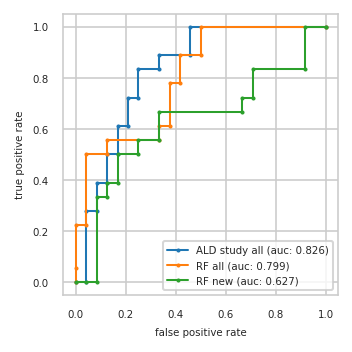

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       RF all       RF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.042 0.000  0.000 0.056  0.042 0.000
2          0.042 0.278  0.000 0.222  0.083 0.000
3          0.083 0.278  0.042 0.222  0.083 0.333
4          0.083 0.389  0.042 0.500  0.125 0.333
5          0.125 0.389  0.125 0.500  0.125 0.389
6          0.125 0.500  0.125 0.556  0.167 0.389
7          0.167 0.500  0.333 0.556  0.167 0.500
8          0.167 0.611  0.333 0.611  0.250 0.500
9          0.208 0.611  0.375 0.611  0.250 0.556
10         0.208 0.722  0.375 0.778  0.333 0.556
11         0.250 0.722  0.417 0.778  0.333 0.667
12         0.250 0.833  0.417 0.889  0.667 0.667
13         0.333 0.833  0.500 0.889  0.667 0.722
14         0.333 0.889  0.500 1.000  0.708 0.722
15         0.458 0.889  1.000 1.000  0.708 0.833
16         0.458 1.000    NaN   NaN  0.917 0.833
17         1.000 1.000    NaN   NaN  0.917 1.000
18           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,RF all,RF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q8NCL4,P01011,A0A0C4DGV8;Q13214;Q13214-2
2,P01701,P08670,A0A0J9YW36;Q9NZ72;Q9NZ72-2
3,Q02818,Q9Y2T3;Q9Y2T3-3,Q9UI40;Q9UI40-2
4,P61981,P61981,P31321
5,P04075,P15151-2,Q96GD0
6,P14174,P04075,J3KSJ8;Q9UD71;Q9UD71-2
7,P00338;P00338-3,Q96GD0,A0A075B7B8
8,Q9Y2T3;Q9Y2T3-3,P25189;P25189-2,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf


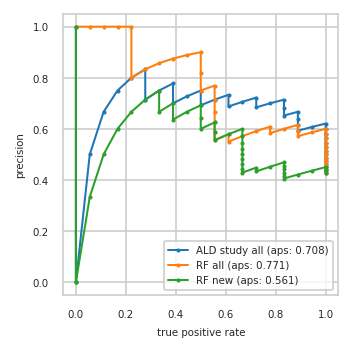

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          RF all          RF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.436 0.944
4          0.474 1.000     0.474 1.000     0.421 0.889
5          0.486 1.000     0.486 1.000     0.405 0.833
6          0.500 1.000     0.500 1.000     0.417 0.833
7          0.514 1.000     0.514 1.000     0.429 0.833
8          0.529 1.000     0.529 1.000     0.441 0.833
9          0.545 1.000     0.545 1.000     0.455 0.833
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.581 1.000     0.581 1.000     0.452 0.778
12         0.600 1.000     0.600 1.000     0.433 0.722
13         0.621 1.000     0.586 0.944     0.448 0.722
14         0.607 0.944     0.571 0.889     0.429 0.667
15         0.593 0.889     0.593 0.889     0.444 0.667
16         0.615 0.889     0.615 0.889     0.462 0.667
17         0.640 0.889     0.600 0.833     0.480 0.667
18         0.667 0.889     0.583 0.778     0.500 0.667
19         0.652 0.833     0.609 0.778     0.522 0.667
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.571 0.667     0.571 0.667
22         0.700 0.778     0.550 0.611     0.600 0.667
23         0.684 0.722     0.579 0.611     0.579 0.611
24         0.722 0.722     0.556 0.556     0.556 0.556
25         0.706 0.667     0.588 0.556     0.588 0.556
26         0.688 0.611     0.625 0.556     0.625 0.556
27         0.733 0.611     0.667 0.556     0.600 0.500
28         0.714 0.556     0.714 0.556     0.643 0.500
29         0.692 0.500     0.769 0.556     0.692 0.500
30         0.750 0.500     0.750 0.500     0.667 0.444
31         0.727 0.444     0.818 0.500     0.636 0.389
32         0.700 0.389     0.900 0.500     0.700 0.389
33         0.778 0.389     0.889 0.444     0.667 0.333
34         0.750 0.333     0.875 0.389     0.750 0.333
35         0.714 0.278     0.857 0.333     0.714 0.278
36         0.833 0.278     0.833 0.278     0.667 0.222
37         0.800 0.222     0.800 0.222     0.600 0.167
38         0.750 0.167     1.000 0.222     0.500 0.111
39         0.667 0.111     1.000 0.167     0.333 0.056
40         0.500 0.056     1.000 0.111     0.000 0.000
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf


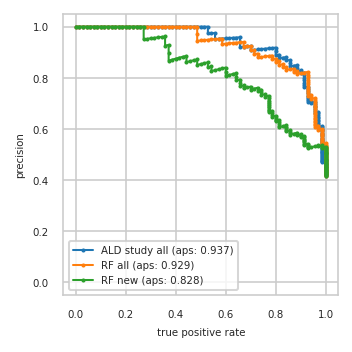

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf


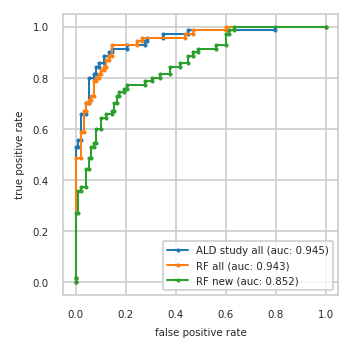

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_RF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF all.pkl'),
 'results_RF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_RF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_RF/auc_roc_curve_train.pdf')}